In [1]:
import igraph as gr
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import networkx as nx
import math
from scipy.stats import genextreme as gev
import scipy.optimize
import random

In [2]:
G = gr.Graph.Famous("zachary")
V = G.vcount()
E = G.ecount()

In [3]:
# Graph routines to calculate isolation and vulnerability index
def isolation(g):
    order = g.vcount()
    infinities = []
    for i in range(0, order):
        graph_copy = g.copy()
# will contain the edge's ids (the ones that will be removed)
        del_list = []
        for target_vertex_id in range(0, order):
            try:
                # Gets the id of the edge that belongs to the pair of vertices
                # (i,target_vertex_id) and puts it in 'del_list'
                del_list.append(graph_copy.get_eid(i, target_vertex_id))
            except:
                pass  # in case the id does not exist
        # deletes all edges connected to the node i
        graph_copy.delete_edges(del_list)
        components_sizes = graph_copy.components().sizes()
        count = 0
        # looping through all components and counting unreachable pairs of
        # vertices in newly modified graph
        total = order
        for c in components_sizes:
            total = total - c
            count += 2*c*total
        infinities.append(count)
    return infinities


def global_efficiency(g):
    invcam = 0
    n = g.vcount()
    global_efficiencies = []
    # returns a list with all shortest paths from each vertex
    shortest_paths = g.shortest_paths_dijkstra()
    for vertex_paths in shortest_paths:
        # iterates on each single shortest path
        for shortest_path in vertex_paths:
            if shortest_path != 0:
                # acumulates the efficiency of each pair of nodes
                invcam += 1 / shortest_path
    # Calculates global efficiency
    eg = invcam / (n * (n - 1))
    global_efficiencies.append(eg)
    return eg


def vulnerability(g):
    vulnerabilities = []
    # Eficiencia com o vertice
    eg = global_efficiency(g)
    # Eficiencia sem o vertice
    # iterating for all vertices
    order = g.vcount()
    for i in range(0, order):
        # makes a copy of the original graph
        g2 = g.copy()
# lista que conterá os ids das arestas do vértice 'i' que serão removidas.
        del_list = []
        for target_vertex_id in range(0, order):
            try:
                # Gets the id of the edge that belongs to the pair of
                # vertices(i,target vertex_id) and puts it in 'del_list'
                del_list.append(g2.get_eid(i, target_vertex_id))
            except:
                pass  # In case the id does not exist
        # deletes all edges of connected to the vertex i
        g2.delete_edges(del_list)
        # gets the efficiency
        efi = global_efficiency(g2)
        # calculates vulnerability
        v = (eg - efi) / eg
        vulnerabilities.append(v)
    return vulnerabilities

def communicability_local(G, p, q, qtd = 11):
    X = G.get_adjacency(2).data
    AUX = np.copy(X)
    G_pq = 0
    for i in range(qtd):
        AUX = np.matmul(AUX, X)
        G_pq += AUX[p][q]/math.factorial(i)
    return G_pq

def communicability_global(G, qtd = 11):
    all_comm = []
    for i in range(G.vcount()):
        for j in range(G.vcount()):
            all_comm.append(communicability_local(G, i, j, qtd))
    return sum(all_comm)/(G.vcount()*(G.vcount())-1)

def vulnerability_comm(G, qtd = 11):
    vul_list = []
    comm = communicability_global(G)
    for i in range(G.vcount()):
        H = G.copy()
        H.delete_edges(H.get_inclist()[i])
        vul_list.append((comm - communicability_global(H, qtd=qtd))/comm)
    return vul_list

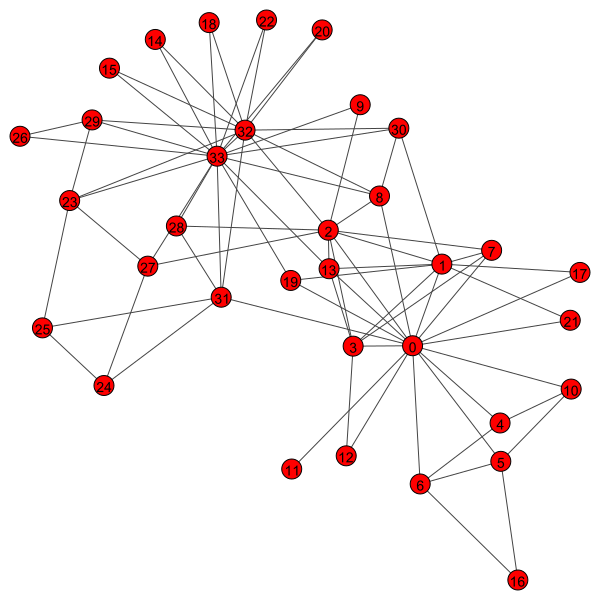

In [4]:
layout = G.layout("kk")
G.vs["label"] = range(V)
gr.plot(G, "karate2.png" ,layout=layout)
# Graph visualization


In [5]:
# Degree to each vertex
G.degree()

[16,
 9,
 10,
 6,
 3,
 4,
 4,
 4,
 5,
 2,
 3,
 1,
 2,
 5,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 5,
 3,
 3,
 2,
 4,
 3,
 4,
 4,
 6,
 12,
 17]

In [6]:
# Mean degree to entire graph
sum(G.degree())/V

4.588235294117647

In [7]:
# Centrality to each vertex
G.closeness()

[0.5689655172413793,
 0.4852941176470588,
 0.559322033898305,
 0.4647887323943662,
 0.3793103448275862,
 0.38372093023255816,
 0.38372093023255816,
 0.44,
 0.515625,
 0.4342105263157895,
 0.3793103448275862,
 0.36666666666666664,
 0.3707865168539326,
 0.515625,
 0.3707865168539326,
 0.3707865168539326,
 0.28448275862068967,
 0.375,
 0.3707865168539326,
 0.5,
 0.3707865168539326,
 0.375,
 0.3707865168539326,
 0.39285714285714285,
 0.375,
 0.375,
 0.3626373626373626,
 0.4583333333333333,
 0.4520547945205479,
 0.38372093023255816,
 0.4583333333333333,
 0.5409836065573771,
 0.515625,
 0.55]

In [8]:
# Mean centrality to the entire graph
c_mean = sum(G.closeness())/V
c_mean

0.4264796325735234

In [9]:
# Shortest paths matrix
np.matrix(G.shortest_paths())

matrix([[0, 1, 1, ..., 1, 2, 2],
        [1, 0, 1, ..., 2, 2, 2],
        [1, 1, 0, ..., 2, 1, 2],
        ...,
        [1, 2, 2, ..., 0, 1, 1],
        [2, 2, 1, ..., 1, 0, 1],
        [2, 2, 2, ..., 1, 1, 0]])

In [10]:
# Minimun shortest path mean to each vertex
min_short = [sum(i)/(V-1) for i in (G.shortest_paths())]
min_short

[1.7575757575757576,
 2.0606060606060606,
 1.7878787878787878,
 2.1515151515151514,
 2.6363636363636362,
 2.606060606060606,
 2.606060606060606,
 2.272727272727273,
 1.9393939393939394,
 2.303030303030303,
 2.6363636363636362,
 2.727272727272727,
 2.696969696969697,
 1.9393939393939394,
 2.696969696969697,
 2.696969696969697,
 3.515151515151515,
 2.6666666666666665,
 2.696969696969697,
 2.0,
 2.696969696969697,
 2.6666666666666665,
 2.696969696969697,
 2.5454545454545454,
 2.6666666666666665,
 2.6666666666666665,
 2.757575757575758,
 2.1818181818181817,
 2.212121212121212,
 2.606060606060606,
 2.1818181818181817,
 1.8484848484848484,
 1.9393939393939394,
 1.8181818181818181]

In [11]:
# Mean shortest path to the entire graph
l_mean = G.average_path_length(directed=False)
l_mean

2.408199643493761

In [12]:
# Graph's diameter
G.diameter(directed=False)

5

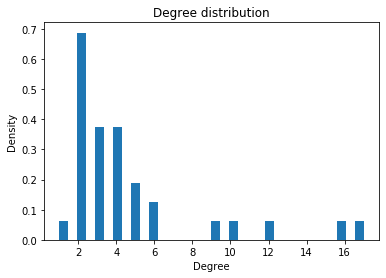

In [13]:
# Plotting the degree distribution as a histogram
plt.figure()
plt.title("Degree distribution")
plt.ylabel("Density")
plt.xlabel("Degree")
plt.hist(G.degree(), bins = V, density = True)
plt.show()

In [14]:
# Centrality to a random graph with the same amount of edges and vertexes
random_net_c = 2*E/(V**2)
random_net_c

0.13494809688581316

In [15]:
# Average path to a random graph with the same amount of edges and vertexes
random_net_l = np.log(V)/(np.log(2*E/V))
random_net_l

2.3146511196218422

In [16]:
# comparing the real one with the similar random one
c_mean > random_net_c

True

In [17]:
l_mean > random_net_l

True

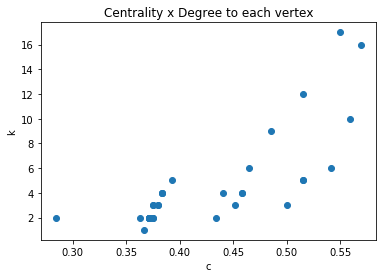

In [18]:
# Plot of centrality x degree to each vertex
plt.plot(G.closeness(), G.degree(), 'o')
plt.title("Centrality x Degree to each vertex")
plt.xlabel("c")
plt.ylabel("k")
plt.show()

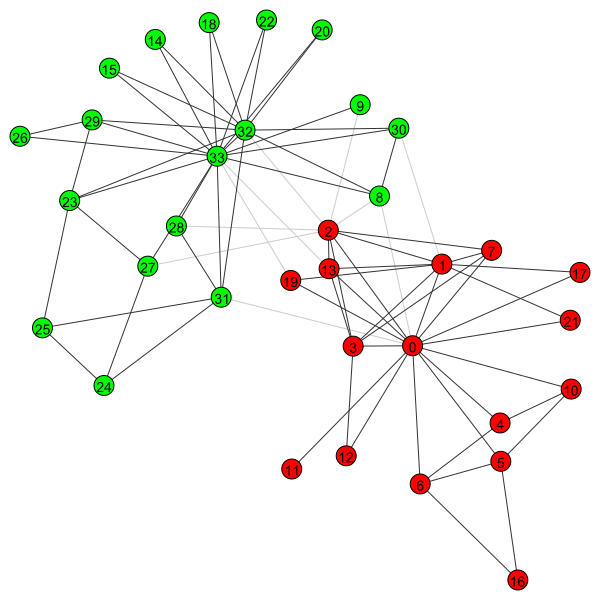

In [19]:
# Community detection via walktrap algorithm
comm = G.community_leading_eigenvector(2)
gr.plot(comm)

In [20]:
# Graph modularity
G.modularity(comm)

0.37146614069691

In [21]:
# Amount of comunities
len(comm)

2

In [22]:
iso = []
vul = []
iso = isolation(G)
vul1 = vulnerability(G)
vul = [round(i, 6) for i in vul1]
convert = G.get_edgelist()
GNX = nx.Graph(convert)
cmap = plt.cm.rainbow
facecolor = "gainsboro"

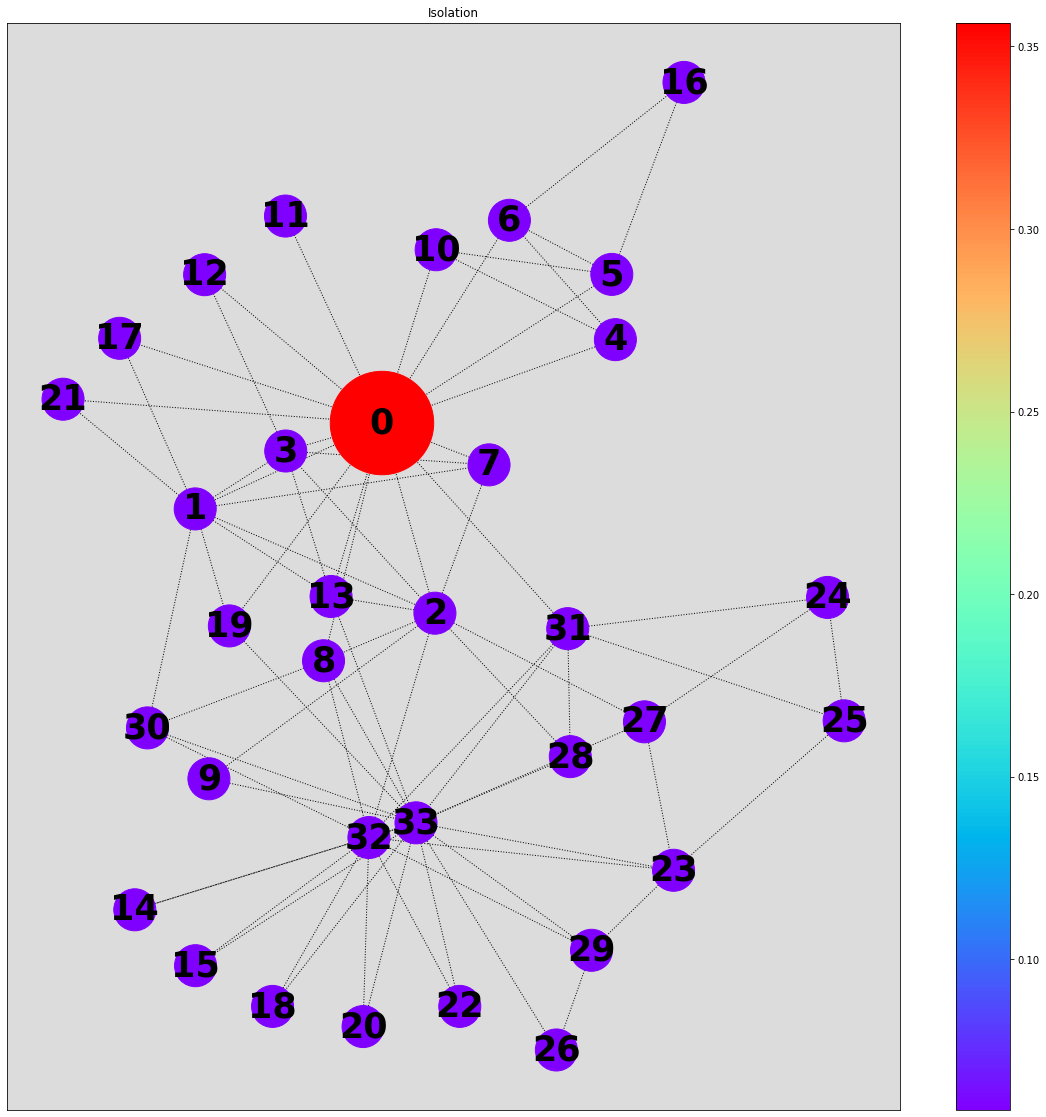

In [23]:
normiso = [float(i)/(V*(V-1)) for i in iso]
norm = matplotlib.colors.Normalize(vmin=min(normiso), vmax=max(normiso))
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_facecolor(facecolor)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # only needed for matplotlib < 3.1
fig.colorbar(sm)
plt.title("Isolation")
nx.draw_networkx(GNX, pos=nx.kamada_kawai_layout(GNX), cmap='rainbow',
                 node_color=normiso, node_size=30000*np.array(normiso),
                 font_color='black', style='dotted', font_weight='heavy',
                 font_size=35)
plt.show()
#Isolation plot

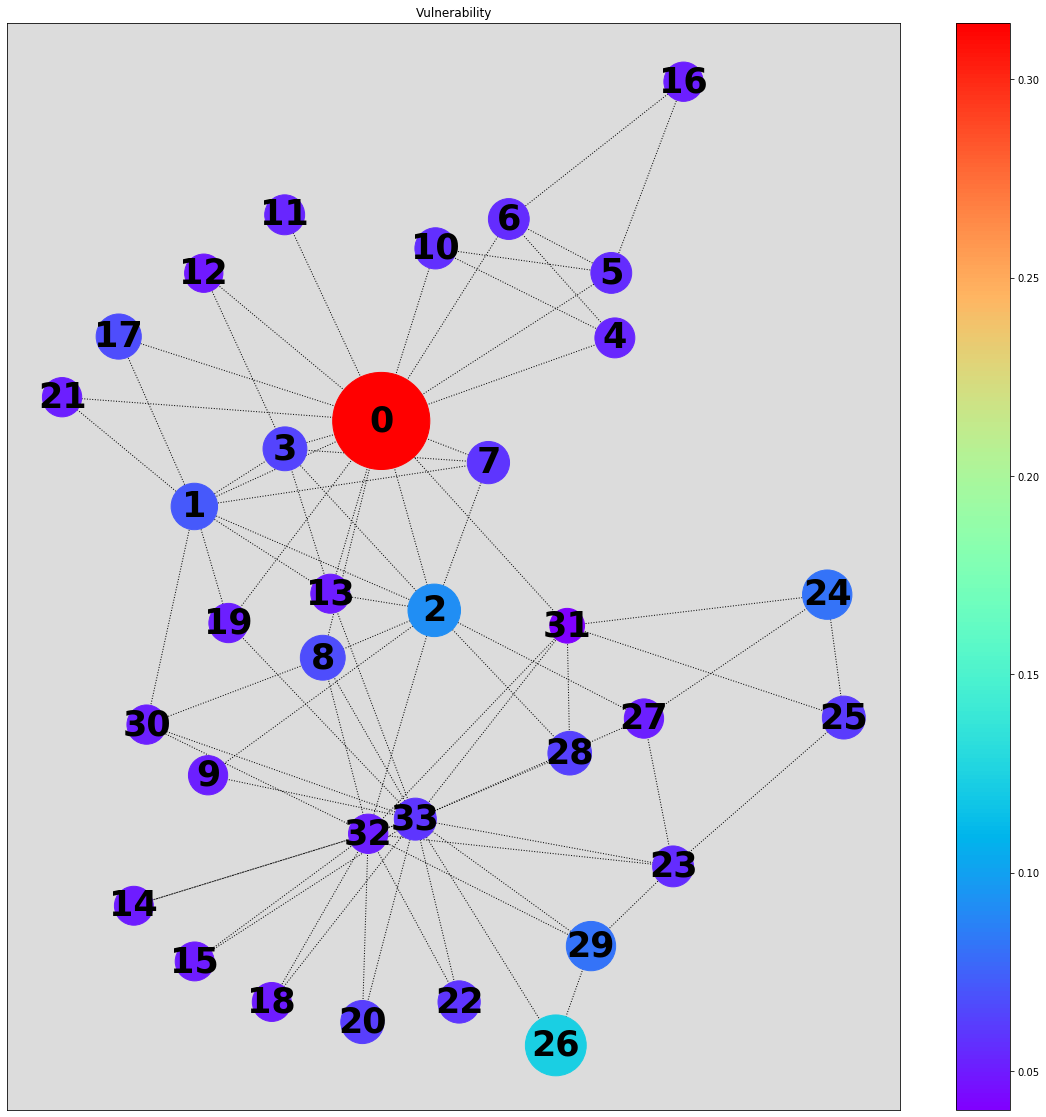

In [24]:
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=min(vul), vmax=max(vul))
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_facecolor(facecolor)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # only needed for matplotlib < 3.1
fig.colorbar(sm)
plt.title("Vulnerability")
nx.draw_networkx(GNX, pos=nx.kamada_kawai_layout(GNX), cmap='rainbow',
                 node_color=vul, node_size=30000*np.array(vul),
                 font_color='black', style='dotted',
                 font_weight='heavy', font_size=35)
plt.show()
# Vulnerablity plot

In [25]:
vul = vulnerability_comm(G)

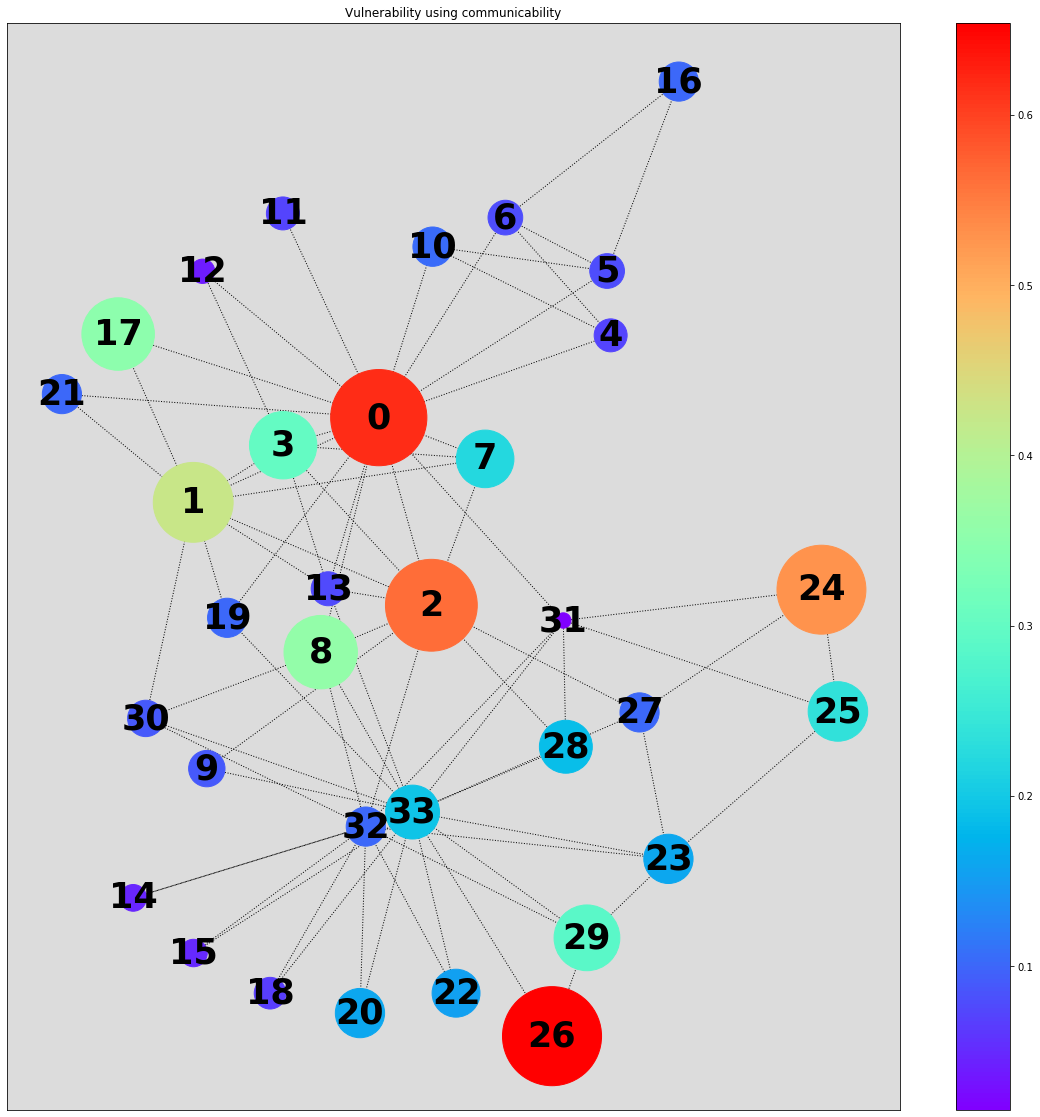

In [26]:
facecolor = "gainsboro"
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=min(vul), vmax=max(vul))
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_facecolor(facecolor)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # only needed for matplotlib < 3.1
fig.colorbar(sm)
plt.title("Vulnerability using communicability")
nx.draw_networkx(GNX, pos=nx.kamada_kawai_layout(GNX), cmap='rainbow',
                 node_color=vul, node_size=15000*np.array(vul),
                 font_color='black', style='dotted',
                 font_weight='heavy', font_size=35)
plt.savefig("vul_comm.pdf")
plt.show()


# Random Walks

In [27]:
def most_frequent(x, short):
    vl = np.zeros(max(x))
    for i in x:
        vl[i-1]+=1
    if short > 1:
        return list(vl).index(max(vl)) - 1
    else:
        return list(vl).index(max(vl))
def random_walk1(G, qtd=10000, steps=100, start=0, finish=1):
    G = gr.Graph.Famous("zachary")
    freq = []
    x = range(G.shortest_paths(start, finish)[0][0], steps)
    for i in range(qtd):
        walk = G.random_walk(start, steps)
        if finish in walk:
            freq.append(walk.index(finish))
    short = G.shortest_paths_dijkstra(start, finish)[0][0]
    plt.title(f"De {start} para {finish}, depois de {qtd} caminhadas")
    plt.ylabel("Probabilidade")
    plt.xlabel("Tamanho da caminhada")
    ypoints=[min(freq) + (i/(steps-short)) * (max(freq)-min(freq)) for i in range(short, steps)]
    c, loc, scale = gev.fit(freq)
    mean, var, skew, kurt = gev.stats(c, moments = "mvsk")
    rv_gev = gev(c, loc=loc, scale=scale)
    gev_pdf = rv_gev.pdf(ypoints)
    n, bins, patches = plt.hist(freq, bins = 100, density = True, label="freq")
    plt.plot(range(short, 100), gev_pdf, label="gev")
    plt.legend()
    plt.show()
    print(f'Most frequent walk: {most_frequent(freq, short)+short} shortest path: {short}' )

def random_walk2(G, qtd=10000, steps=100, start=0, finish=1):
    y = []
    summing = [0]
    x = range(G.shortest_paths(start, finish)[0][0], steps)
    for i in x:
        freq = []
        for j in range(qtd):
            freq.append(G.random_walk(start, i)[-1])
        y.append(freq.count(finish)/qtd)
        summing.append(summing[-1] + freq.count(finish)/((len(summing)+1)*qtd))

    summing.pop(0)

    plt.figure()
    plt.title(f"Porcentagem das vezes que a caminhada\n aleatória leva ao destino")
    plt.xlabel("Quantidade de passos")
    plt.ylabel("Frequência")
    plt.plot(x, y, label="data")
    plt.legend()
    plt.show()


    fit = scipy.optimize.curve_fit(lambda t,a,b: a+b*np.log(t),  x,  summing)
    yy = [(fit[0][0]+fit[0][1]*i) for i in np.log(x)]
    plt.figure()
    plt.title(f"Chance que a caminhada aleatória tem de chegar no\n destino acumulando os passos\n {str(fit[0][0])[:6]} + {str(fit[0][1])[:4]}*log(x)")
    plt.xlabel("Quantidade de passos")
    plt.ylabel("Chance de aparecer na somatória")
    plt.plot(x, yy, label = "fit")
    plt.plot(x, summing, label = "data")
    plt.legend()
    plt.show()

C:\Users\gio-x\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2594: RuntimeWarning: invalid value encountered in power
  np.sign(c)*(-g3 + (g2 + 2*g2mg12)*g1)/g2mg12**1.5,


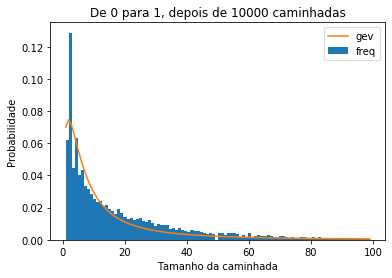

Most frequent walk: 2 shortest path: 1


In [28]:
random_walk1(G)

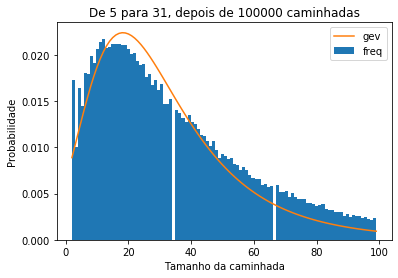

Most frequent walk: 12 shortest path: 2


In [29]:
random_walk1(G, qtd = 100000, start=5, finish=31)

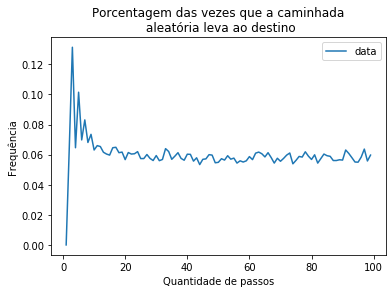

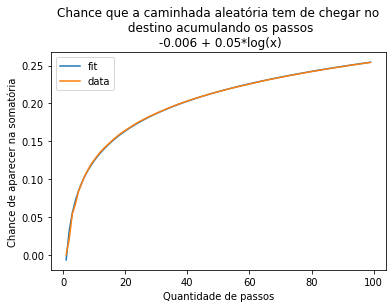

In [30]:
random_walk2(G)

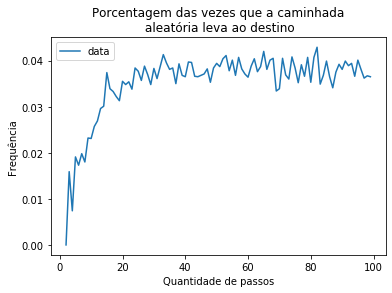

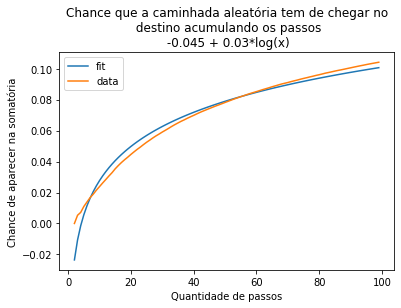

In [31]:
random_walk2(G, start = 5, finish = 31)

In [32]:
def self_avoiding(G, start, finish, qtd=10000, steps = 30):
    steps_to_achv = []
    i = 0
    while i < qtd:
        x = start
        count = 0
        visited = []
        flag = True
        while(x != finish and count < steps and flag):
            visited.append(x)
            count += 1
            possible_neigh = list(set(G.get_adjlist()[x]) - set(visited))
            if len(possible_neigh) == 0:
                flag = False
                count = -1
            else:
                x = possible_neigh[random.randint(0,len(possible_neigh)-1)]
        if count != -1:
            i+=1
            steps_to_achv.append(count)
    
    plt.title(f"De {start} para {finish}, depois de {qtd} caminhadas")
    plt.ylabel("Probabilidade")
    plt.xlabel("Tamanho da caminhada")
    plt.hist(steps_to_achv, bins = 100, density = True)
    plt.show()
    short = G.shortest_paths_dijkstra(start, finish)[0][0]
    print(f'Most frequent walk: {most_frequent(steps_to_achv, short)+short} shortest path: {short}' )

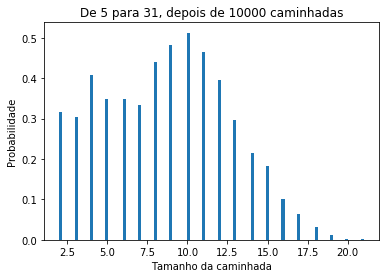

Most frequent walk: 10 shortest path: 2


In [33]:
self_avoiding(G, 5, 31)